In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr

import numpy as np

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from salt.models import SALT

from ssm.plots import gradient_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from ssm.utils import find_permutation

2024-06-17 00:13:20.421801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
K = num_states = 2
N = num_emission_dims = 5
L = num_lags = 7
core_tensor_dims = (3, 3, 3)

transition_matrix = 0.95 * jnp.eye(num_states) + 0.05 / (num_states - 1) * (1 - jnp.eye(num_states))

seed = jr.PRNGKey(0)
this_seed, seed = jr.split(seed, 2)
covariance_matrix_sqrts = \
    jnp.linalg.cholesky(
        tfd.WishartTriL(num_emission_dims + 2, 1e-1*jnp.eye(num_emission_dims))\
        .sample(seed=this_seed, sample_shape=(num_states,)))

emission_lag_factors = jnp.zeros((num_states, num_lags, core_tensor_dims[2]))
for k in range(num_states):
    for l in range(num_lags):
        this_seed, seed = jr.split(seed, 2)
        emission_lag_factors_kl = tfd.Normal(0, 0.1*0.5**l).sample(
            seed=this_seed,
            sample_shape=(core_tensor_dims[2]))
        emission_lag_factors = emission_lag_factors.at[k,-1-l].set(emission_lag_factors_kl)

this_seed, seed = jr.split(seed, 2)
emission_biases = tfd.Normal(0, 1).sample(seed=this_seed, sample_shape=(num_emission_dims,))
emission_biases /= jnp.linalg.norm(emission_biases, ord=2, axis=-1, keepdims=True)

model = SALT(num_states=num_states,
             num_emission_dims=num_emission_dims,
             num_lags=num_lags,
             core_tensor_dims=core_tensor_dims,
             transition_matrix=transition_matrix,
             emission_lag_factors=emission_lag_factors,
             emission_covariance_matrix_sqrts=covariance_matrix_sqrts,
             emission_biases=emission_biases,
             single_subspace=True,
             seed=jr.PRNGKey(0),
             mode='cp')

2024-06-17 00:13:26.155104: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
states, data = model.sample(jr.PRNGKey(0), 5000)

Text(0.5, 0, 'time')

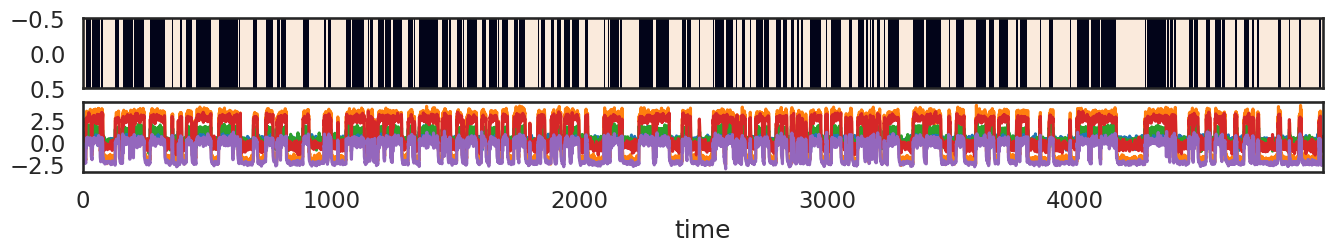

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16,2), sharex=True)
axs[0].imshow(states[None, :], interpolation="none", aspect="auto")
axs[1].plot(data)
axs[1].set_xlabel("time")

In [6]:
test_model = SALT(num_states=num_states,
                  num_emission_dims=num_emission_dims,
                  num_lags=num_lags,
                  core_tensor_dims=core_tensor_dims,
                  single_subspace=True,
                  seed=jr.PRNGKey(1),
                  mode='cp')

print(model.marginal_likelihood(data, None))
print(test_model.marginal_likelihood(data, None))

6495.721841178602
-1104578.4920508629


In [7]:
lps, test_model, posterior = test_model.fit(data, num_iters=1000, method='em')

Initializing...
Done.


  0%|          | 0/500 [00:00<?, ?it/s]

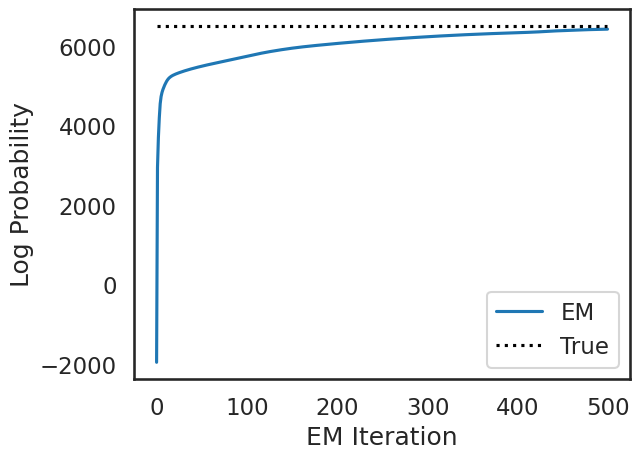

In [8]:
# Plot the log likelihoods against the true likelihood, for comparison
true_lp = model.marginal_likelihood(data)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

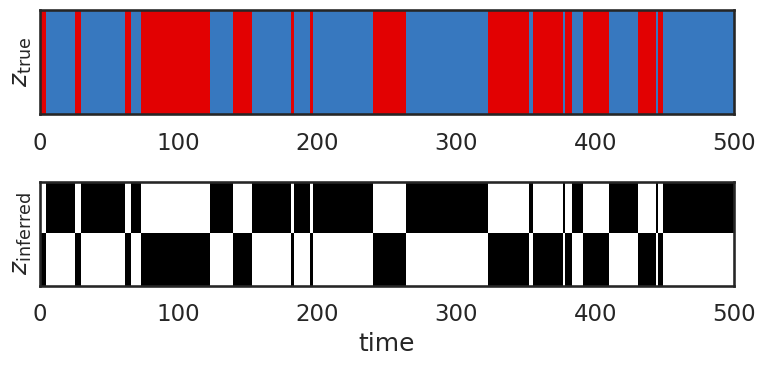

In [9]:
# Plot the true and inferred discrete states
plot_slice = (0, 500)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
# plt.imshow(most_likely_states[None,: :], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.imshow(posterior['expected_states'][0,num_lags:].T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [10]:
permutation = find_permutation(states[num_lags:].astype(jnp.int32), 
                 posterior['expected_states'][0,num_lags:].argmax(1).astype(jnp.int32))

In [11]:
ground_truth_output_factors = model._emissions.output_factors
ground_truth_lowD_dynamics = model._emissions.lowD_dynamics
ground_truth_core_tensors = model._emissions.core_tensors
ground_truth_input_factors = model._emissions.input_factors
ground_truth_lag_factors = model._emissions.lag_factors

inferred_output_factors = test_model._emissions.output_factors
inferred_lowD_dynamics = test_model._emissions.lowD_dynamics
inferred_core_tensors = test_model._emissions.core_tensors
inferred_input_factors = test_model._emissions.input_factors
inferred_lag_factors = test_model._emissions.lag_factors

In [12]:
def reconstruct_tensor(output_factors, core_tensors, input_factors, lag_factors, lowD_dynamics):
    
    reconstructed = jnp.einsum('...def,...ix,...je,...lf,...xd->...ijl',
                              core_tensors,
                              output_factors,
                              input_factors,
                              lag_factors,
                              lowD_dynamics)
    
    return reconstructed

In [13]:
ground_truth_tensor = reconstruct_tensor(ground_truth_output_factors,
                                         ground_truth_core_tensors,
                                         ground_truth_input_factors,
                                         ground_truth_lag_factors,
                                         ground_truth_lowD_dynamics)

inferred_tensor = reconstruct_tensor(inferred_output_factors,
                                     inferred_core_tensors,
                                     inferred_input_factors,
                                     inferred_lag_factors,
                                     inferred_lowD_dynamics)

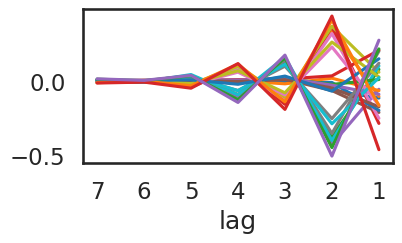

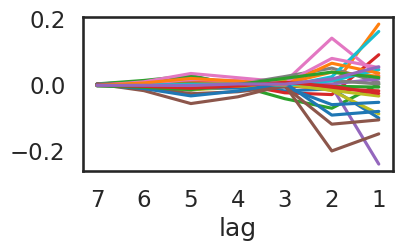

In [14]:
# visualize each entry of the tensor
for k in range(num_states):
    plt.figure(figsize=(4,2))
    for i in range(N):
        for j in range(N):
            plt.plot(np.arange(L)+1, ground_truth_tensor[k,i,j])
    plt.xticks(np.arange(L)+1, np.flip(np.arange(L)+1))
    plt.xlabel('lag')
    plt.show()

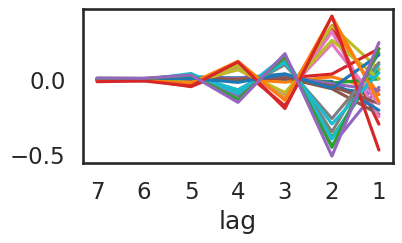

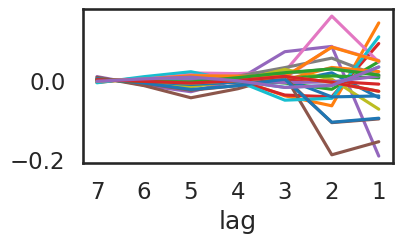

In [15]:
# visualize each entry of the tensor
for k in range(num_states):
    plt.figure(figsize=(4,2))
    for i in range(N):
        for j in range(N):
            plt.plot(np.arange(L)+1, inferred_tensor[permutation[k],i,j])
    plt.xticks(np.arange(L)+1, np.flip(np.arange(L)+1))
    plt.xlabel('lag')
    plt.show()

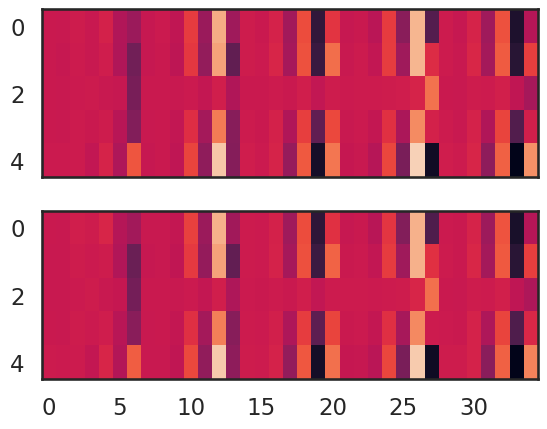

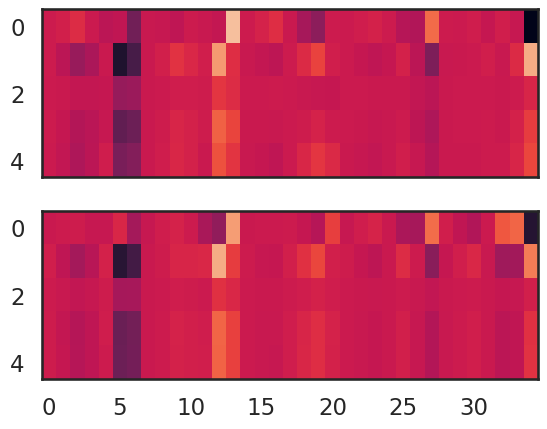

In [16]:
for k in range(num_states):
    fig, axs = plt.subplots(2, 1, sharex=True)
    lim = max(abs(ground_truth_tensor[k]).max(), abs(inferred_tensor[permutation[k]]).max())
    axs[0].imshow(ground_truth_tensor[k].reshape(N, N * L), vmin=-lim, vmax=lim, aspect="auto")
    axs[1].imshow(inferred_tensor[permutation[k]].reshape(N, N * L), vmin=-lim, vmax=lim, aspect="auto")
    plt.show()